In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-nlp/Corona_NLP_test.csv
/kaggle/input/covid-nlp/Corona_NLP_train.csv


### 0. Importing all the basic libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### 1. Importing the data

In [3]:
train = pd.read_csv('/kaggle/input/covid-nlp/Corona_NLP_train.csv', encoding='latin1')
test = pd.read_csv('/kaggle/input/covid-nlp/Corona_NLP_test.csv', encoding='latin1')

# let's check the shape of our data
print(train.shape)
print(test.shape)

# let's check the head of our data
train.head()


(41157, 6)
(3798, 6)


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


### Let's check out the distribution per sentiment

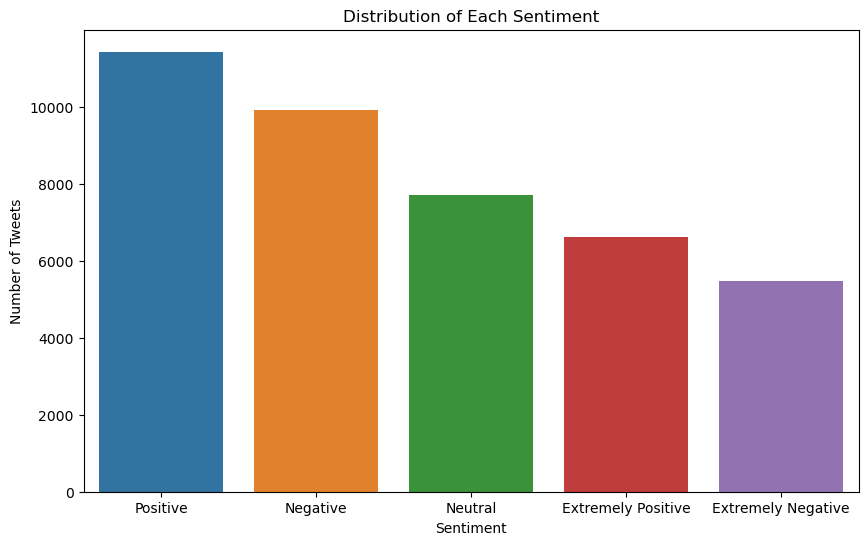

In [4]:
# Count the occurrences of each sentiment
sentiment_counts = train['Sentiment'].value_counts()

# Plot the data
plt.figure(figsize=(10,6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Distribution of Each Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

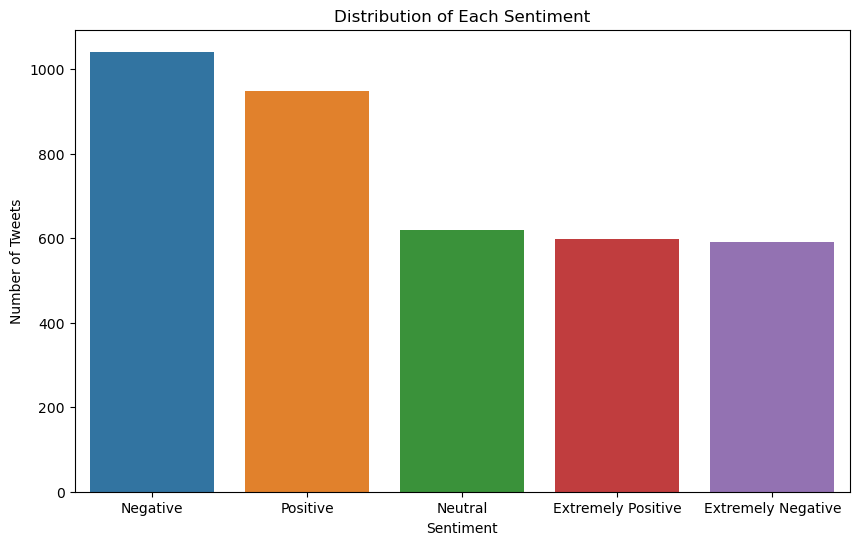

In [5]:
# Count the occurrences of each sentiment in the test set
sentiment_counts = test['Sentiment'].value_counts()

# Plot the data
plt.figure(figsize=(10,6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Distribution of Each Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()


Neutrals a little less in Test set, in comparison against the extremes. But practically a similar distribution (almost iid)

### Frequency of tweets over time:

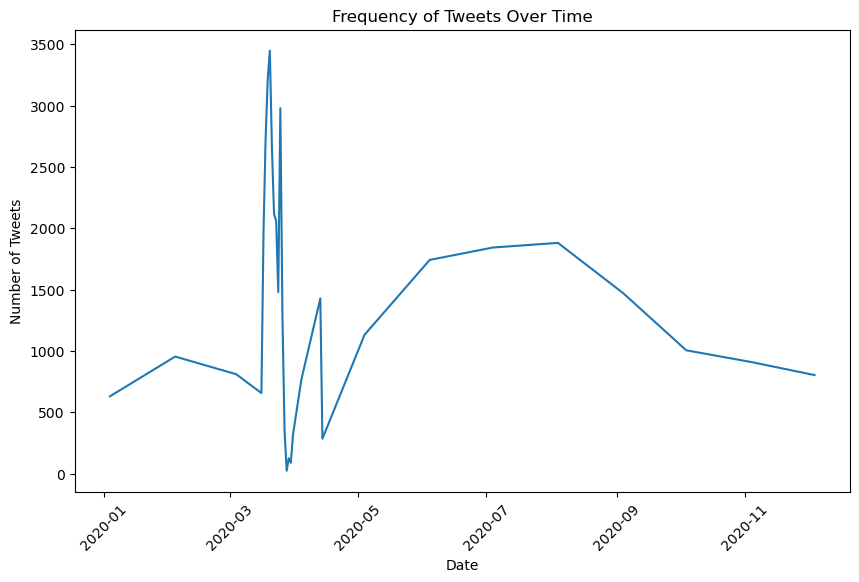

In [6]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Convert 'TweetAt' column to datetime
train['TweetAt'] = pd.to_datetime(train['TweetAt'])

# Count the number of tweets per day
tweets_per_day = train['TweetAt'].value_counts().sort_index()

# Plot the data
plt.figure(figsize=(10,6))
sns.lineplot(x=tweets_per_day.index, y=tweets_per_day.values)
plt.title('Frequency of Tweets Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.show()

### The spike at the end of march mostly pertains to lockdown

### Next, let's proceed with the second visualization: "Number of Tweets by Location". We'll plot the top 20 locations with the most tweets for clarity.

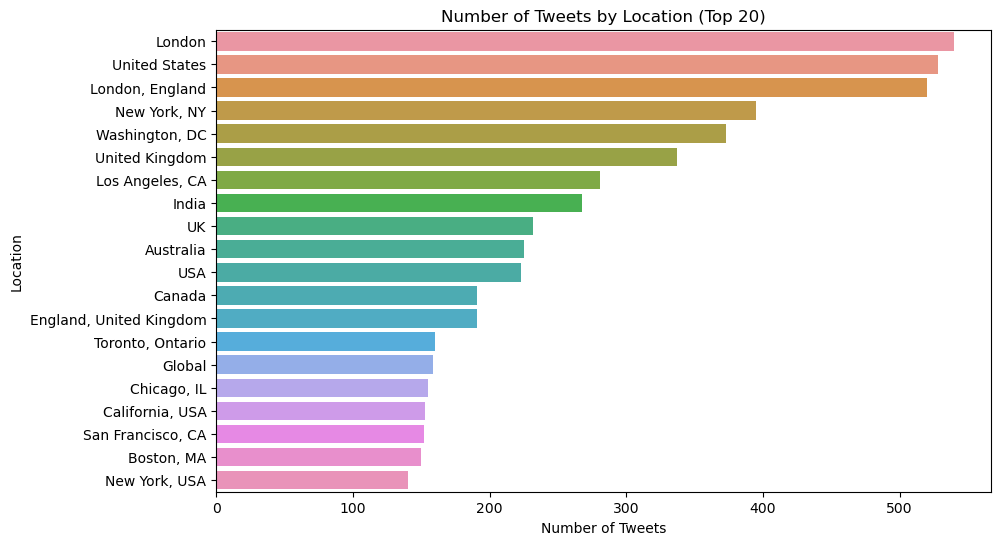

In [7]:
# Count the number of tweets per location
tweets_per_location = train['Location'].value_counts().nlargest(20)

# Plot the data
plt.figure(figsize=(10,6))
sns.barplot(x=tweets_per_location.values, y=tweets_per_location.index)
plt.title('Number of Tweets by Location (Top 20)')
plt.xlabel('Number of Tweets')
plt.ylabel('Location')
plt.show()


### *Distribution of Sentiments by Location*. Since we have many locations, we'll focus on the top 20 locations with the most tweets for clarity.

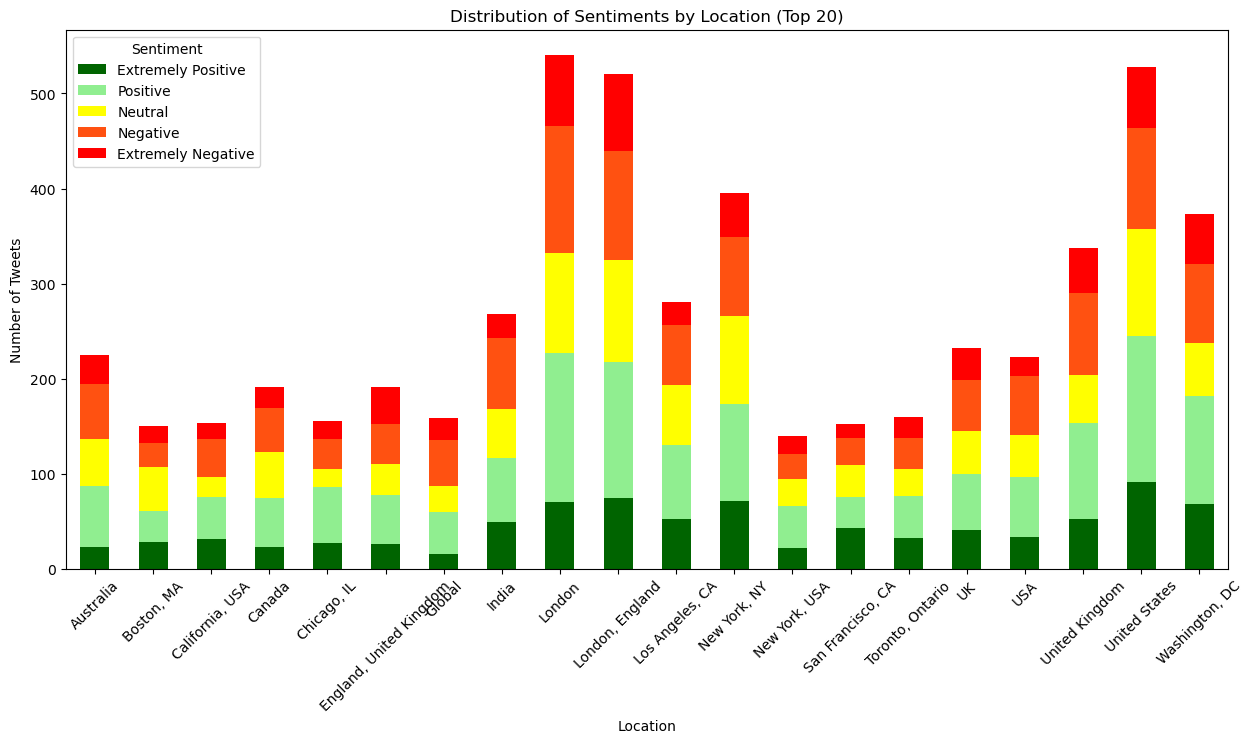

In [8]:
# Get the top 20 locations with the most tweets
top_locations = train['Location'].value_counts().nlargest(20).index

# Filter the data to include only the top 20 locations
data_top_locations = train[train['Location'].isin(top_locations)]

# Group the data by location and sentiment, and then count the occurrences of each sentiment in each location
sentiment_per_location = data_top_locations.groupby(['Location', 'Sentiment']).size().unstack(fill_value=0)
# Change the order of the sentiments
sentiment_order = ['Extremely Positive', 'Positive', 'Neutral', 'Negative', 'Extremely Negative']
sentiment_per_location = sentiment_per_location[sentiment_order]

colors = ['#006400', '#90EE90', '#FFFF00', '#FF5111', '#FF0000']

# Plot the data
sentiment_per_location.plot(kind='bar', stacked=True, figsize=(15,7), color=colors)
plt.title('Distribution of Sentiments by Location (Top 20)')
plt.xlabel('Location')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.show()

### Let's go ahead and process the tweets:

In [9]:
import re
import string

def preprocess_text(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove user mentions
    text = re.sub(r'\@\w+','', text)
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Convert the text to lowercase
    text = text.lower()
    return text

# Apply the preprocessing to the OriginalTweet column
train['ProcessedTweet'] = train['OriginalTweet'].apply(preprocess_text)
test['ProcessedTweet'] = test['OriginalTweet'].apply(preprocess_text)

train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,ProcessedTweet
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,and and
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,advice talk to your neighbours family to excha...
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths to give elder...
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive,my food stock is not the only one which is emp...
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready to go at supermarket during the covid...
...,...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",2020-04-14,Airline pilots offering to stock supermarket s...,Neutral,airline pilots offering to stock supermarket s...
41153,44952,89904,NaN,2020-04-14,Response to complaint not provided citing COVI...,Extremely Negative,response to complaint not provided citing covi...
41154,44953,89905,NaN,2020-04-14,You know itÂs getting tough when @KameronWild...,Positive,you know itâs getting tough when is rationi...
41155,44954,89906,NaN,2020-04-14,Is it wrong that the smell of hand sanitizer i...,Neutral,is it wrong that the smell of hand sanitizer i...


In [10]:
train['OriginalTweet'][0]

'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8'

#### Limitation: As you can see the context of this tweet in held in the links mentioned on the tweet, which is out of the domains of natural language. 
* More rigorous preprocessing would see us scraping words out of each link 
* We could also use OCr incase of attached images
But these are jsut possible increases in scope that we won't be exploring.

### I insist on in depth visualizations as they help tell the story of any data

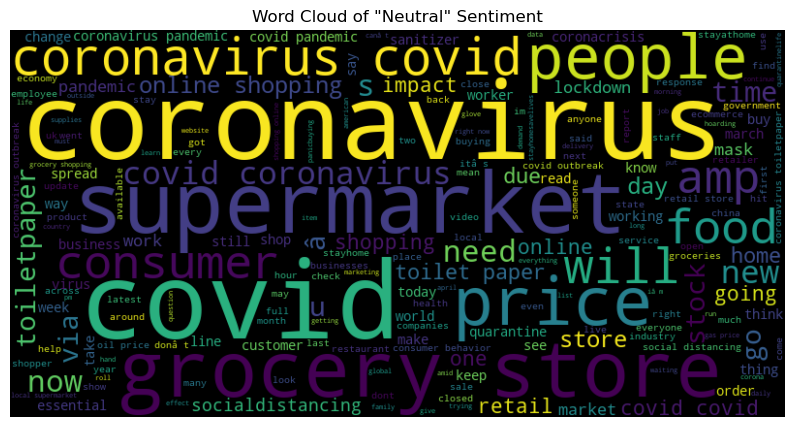

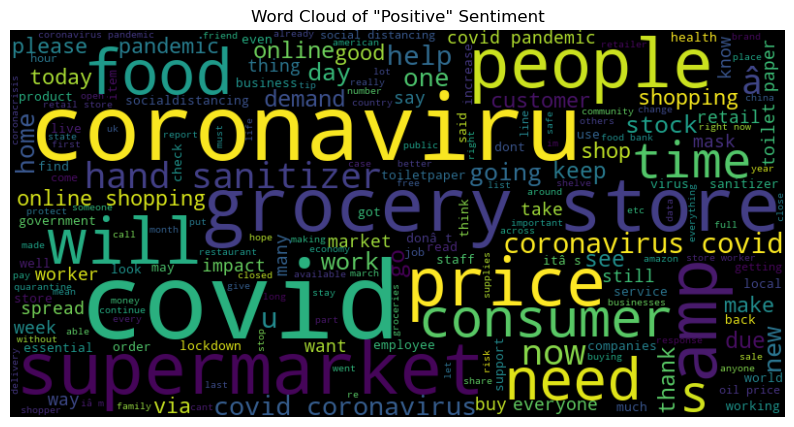

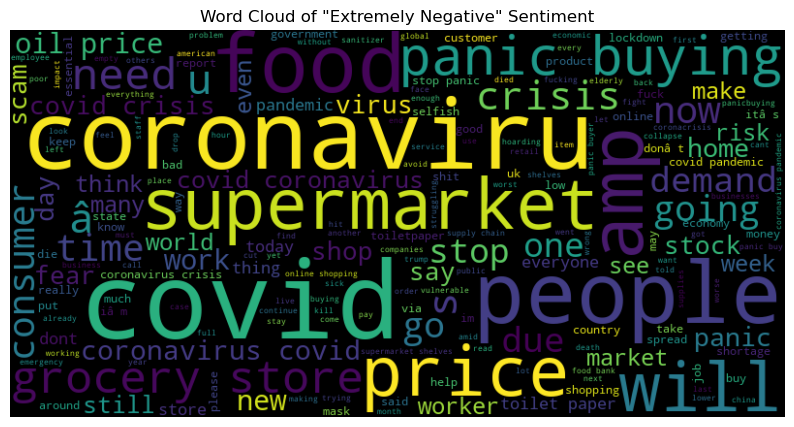

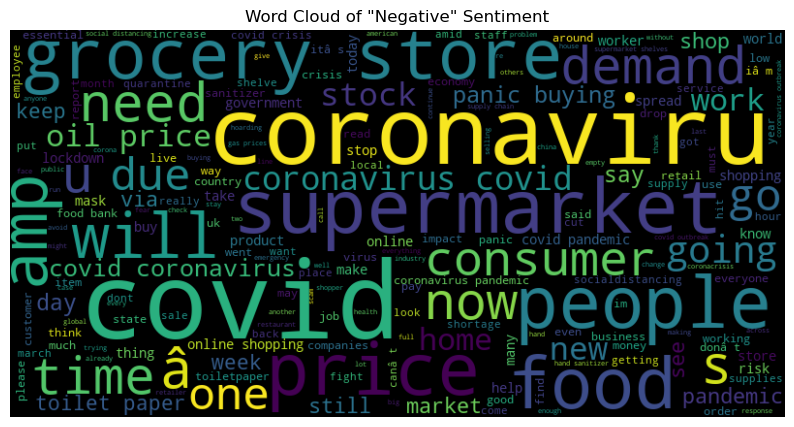

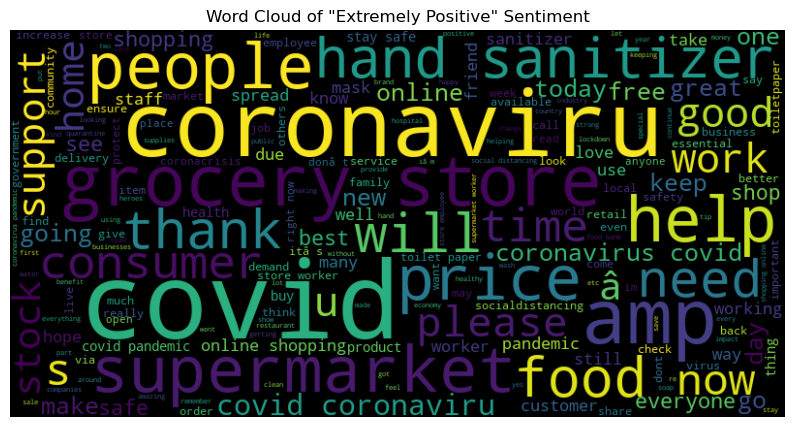

In [11]:
from wordcloud import WordCloud

# Define the sentiments
sentiments = train['Sentiment'].unique()

# Generate a word cloud for each sentiment
for sentiment in sentiments:
    # Get the tweets of the current sentiment
    tweets = train[train['Sentiment'] == sentiment]['ProcessedTweet']
    # Join the tweets to a single string
    text = ' '.join(tweets)
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(text)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title('Word Cloud of "{}" Sentiment'.format(sentiment))
    plt.show()


### 4. Machine Learning models

In [12]:
from sklearn.model_selection import train_test_split

X_train = train['ProcessedTweet']
y_train = train['Sentiment']
X_test = test['ProcessedTweet']
y_test = test['Sentiment']


In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Define the pipelines
pipelines = [
    ("lr", Pipeline([('vect', CountVectorizer()), ('clf', LogisticRegression())])),
    ("rf", Pipeline([('vect', CountVectorizer()), ('clf', RandomForestClassifier())])),
    ("svc", Pipeline([('vect', CountVectorizer()), ('clf', LinearSVC())])),
    ("nb", Pipeline([('vect', CountVectorizer()), ('clf', MultinomialNB())]))
]

# Train and evaluate the models
for name, pipeline in pipelines:
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)
    
    # Evaluate the model
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))


Classification Report for lr:
                    precision    recall  f1-score   support

Extremely Negative       0.69      0.54      0.61       592
Extremely Positive       0.73      0.60      0.66       599
          Negative       0.55      0.58      0.56      1041
           Neutral       0.62      0.71      0.67       619
          Positive       0.55      0.61      0.58       947

          accuracy                           0.60      3798
         macro avg       0.63      0.61      0.61      3798
      weighted avg       0.61      0.60      0.61      3798

Classification Report for rf:
                    precision    recall  f1-score   support

Extremely Negative       0.63      0.23      0.34       592
Extremely Positive       0.71      0.26      0.38       599
          Negative       0.44      0.45      0.44      1041
           Neutral       0.52      0.65      0.58       619
          Positive       0.38      0.60      0.46       947

          accuracy                 

In [14]:
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder

# Initialize the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)  # num_labels depends on your number of unique sentiment categories

# Tokenize the input data
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=512)

# Convert labels to numerical values
le = LabelEncoder()
y_train_num = le.fit_transform(y_train)
y_test_num = le.transform(y_test)

# Prepare the data for PyTorch
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, y_train_num)
test_dataset = TweetDataset(test_encodings, y_test_num)

# Set up the Trainer
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate()


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.we

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:55                                                                                   │
│                                                                                                  │
│   52 )                                                                                           │
│   53                                                                                             │
│   54 # Train the model                                                                           │
│ ❱ 55 trainer.train()                                                                             │
│   56                                                                                             │
│   57 # Evaluate the model                                                                        │
│   58 trainer.evaluate()                                                                          │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/transformers/trainer.py:1645 in train                    │
│                                                                                                  │
│   1642 │   │   inner_training_loop = find_executable_batch_size(                                 │
│   1643 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batch_size  │
│   1644 │   │   )                                                                                 │
│ ❱ 1645 │   │   return inner_training_loop(                                                       │
│   1646 │   │   │   args=args,                                                                    │
│   1647 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                                │
│   1648 │   │   │   trial=trial,                                                                  │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/transformers/trainer.py:1862 in _inner_training_loop     │
│                                                                                                  │
│   1859 │   │   self._globalstep_last_logged = self.state.global_step                             │
│   1860 │   │   model.zero_grad()                                                                 │
│   1861 │   │                                                                                     │
│ ❱ 1862 │   │   self.control = self.callback_handler.on_train_begin(args, self.state, self.contr  │
│   1863 │   │                                                                                     │
│   1864 │   │   # Skip the first epochs_trained epochs to get the random state of the dataloader  │
│   1865 │   │   if not args.ignore_data_skip:                                                     │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/transformers/trainer_callback.py:353 in on_train_begin   │
│                                                                                                  │
│   350 │                                                                                          │
│   351 │   def on_train_begin(self, args: TrainingArguments, state: TrainerState, control: Trai   │
│   352 │   │   control.should_training_stop = False                                               │
│ ❱ 353 │   │   return self.call_event("on_train_begin", args, state, control)                     │
│   354 │                                                                                          │
│   355 │   def on_train_end(self, args: TrainingArguments, state: TrainerState, control: Traine   │
│   356 │   │   return self.call_event("on_train_end", args, 

In [ ]:
# Get the predictions
predictions = trainer.predict(test_dataset)

# The predictions are logits. We need to convert them to class indices
predicted_labels = np.argmax(predictions.predictions, axis=-1)

In [ ]:
from sklearn.metrics import classification_report

# Get the true labels from the test dataset
true_labels = y_test_num.tolist()

# Compute the classification report
report = classification_report(true_labels, predicted_labels, target_names=le.classes_, digits=4)

print(report)


### We can see an increase in all metrics including f1 scores per class and also the overall accuracy.
Factors that contribute to DistilBERT's superior performance:
* Context: DistilBERT understands the context of a sentence, which allows it to capture the relationships between different words and the nuances of language.
* Pre-training: DistilBERT is pre-trained on a large corpus of text, which allows it to learn a general understanding of language.
* Transfer learning: DistilBERT can be fine-tuned for specific tasks, which often leads to better performance compared to models trained from scratch or with less comprehensive pre-training.
* Word variations: DistilBERT can handle a wide range of words, including rare and out-of-vocabulary words.

Some other models that could be better for production, depending on our specific needs. An app with all the following option could be created: 

| Model | Pros | Cons |
|---|---|---|
| DistilBERT | Efficient | Not the most accurate |
| BERT | Accurate | Not as efficient as DistilBERT |
| RoBERTa | Accurate and efficient | Not as simple as DistilBERT |
| XLNet | Most accurate | Complex |